<a href="https://colab.research.google.com/github/PratyushNag/Fraud-Detection/blob/main/Fraud_dectection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data

In [ ]:
from google.colab import files

#upload the given dataset
files.upload()

{}

## Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from skimage.io import imread
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import average_precision_score, confusion_matrix, f1_score, precision_recall_curve, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import Sequential
from keras.applications import MobileNetV2
from keras.layers import Dense
from keras.preprocessing import image
from collections import Counter

In [ ]:
#read csv file
fraud_df = pd.read_csv('./Fraud.csv')
fraud_df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0.0,0.0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0.0,0.0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0.0,0.0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0.0,0.0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0.0,0.0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0.0,0.0


# Cleaning the Dataset
dropping null value rows,  encoding labels, counting the label y

In [ ]:
encoded_labels, unique_categories=pd.factorize(fraud_df['type'])
le = LabelEncoder()
le.fit(unique_categories)
fraud_df ['type']= le.transform(fraud_df['type'])
fraud_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0.0,0.0
1,1,3,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0.0,0.0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1.0,0.0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1.0,0.0
4,1,3,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3196170,249,1,13134.43,C1478041693,0.0,0.00,C1215968353,189641.83,202776.26,0.0,0.0
3196171,249,1,151354.38,C2114061075,0.0,0.00,C2129651802,1823220.95,1974575.33,0.0,0.0
3196172,249,1,191940.36,C1800466589,0.0,0.00,C1981566667,2340641.02,2532581.38,0.0,0.0
3196173,249,1,168661.77,C1145327772,0.0,0.00,C1215437005,1882480.85,2051142.62,0.0,0.0


In [ ]:
def labels(x):
    if x == 0.0:
        return 1.0
    else:
        return -1

In [ ]:
fraud_df = fraud_df.drop('nameOrig', axis=1)
fraud_df = fraud_df.drop('nameDest', axis=1)
fraud_df.dropna(inplace=True)

In [ ]:
fraud_df['isFraud'] = fraud_df['isFraud'].apply(labels)
#count values of label y
#fraud_df['isFraud'].value_counts(dropna=True)
frac = Counter(np.where(fraud_df['isFraud']==1,1,-1))
print(frac)

Counter({1: 3193379, -1: 2795})


In [ ]:
contamination = list(frac.values())[1] / list(frac.values())[0]
contamination

0.0008752484437331116

Here we can see that the dataset is skewed, Hence we will proceed to use anomaly detection, and not supervised learning

In [ ]:
fraud_df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.0,160296.36,0.00,0.00,1.0,0.0
1,1,3,1864.28,21249.0,19384.72,0.00,0.00,1.0,0.0
2,1,4,181.00,181.0,0.00,0.00,0.00,-1.0,0.0
3,1,1,181.00,181.0,0.00,21182.00,0.00,-1.0,0.0
4,1,3,11668.14,41554.0,29885.86,0.00,0.00,1.0,0.0
...,...,...,...,...,...,...,...,...,...
3196169,249,1,44505.68,0.0,0.00,153149.72,197655.40,1.0,0.0
3196170,249,1,13134.43,0.0,0.00,189641.83,202776.26,1.0,0.0
3196171,249,1,151354.38,0.0,0.00,1823220.95,1974575.33,1.0,0.0
3196172,249,1,191940.36,0.0,0.00,2340641.02,2532581.38,1.0,0.0


In [ ]:
filt =fraud_df['isFraud']==1
train_df=fraud_df.loc[filt==False]
dev_df =fraud_df.loc[filt]
train_df.shape

(2795, 9)

Splitting the dataset to training set(80%), Testing set (10%) and Dev set (10%)

In [ ]:
X_train, X_ = train_test_split(train_df, test_size=0.2, random_state=42)
X_ = X_.append(dev_df, ignore_index=True)
y=X_['isFraud']
X_train = X_train.drop('isFraud', axis=1)
X_ = X_.drop('isFraud', axis=1)
X_test, X_dev, y_test, y_dev=train_test_split(X_,y, test_size=0.5, random_state =42)
print('The shape of the X_train :'+' '+str(X_train.shape))
print('The shape of the X_test :'+' '+str(X_test.shape))
print('The shape of the y_test :'+' '+str(y_test.shape))
print('The shape of the X_dev :'+' '+str(X_dev.shape))
print('The shape of the y_dev :'+' '+str(y_dev.shape))

<ipython-input-150-215d3014724e>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_ = X_.append(dev_df, ignore_index=True)


The shape of the X_train : (2236, 8)
The shape of the X_test : (1596969, 8)
The shape of the y_test : (1596969,)
The shape of the X_dev : (1596969, 8)
The shape of the y_dev : (1596969,)


# Creating and Fitting the Model
The *Elliptic Envelope* algorithm is used for identifying outliers in a dataset assuming that the inliers are Gaussian distributed. It fits an elliptical envelope to the central data points, excluding potential outliers. The algorithm assumes that the normal instances in the data follow a **Gaussian distribution**, and it estimates the mean and covariance of the data to define an elliptical region where normal instances are likely to fall.

In [ ]:
model = EllipticEnvelope(contamination=contamination)
model.fit(X_train)

EllipticEnvelope(contamination=0.0008752484437331116)

In [ ]:
model.get_precision()

array([[ 1.93983399e-04,  1.72752435e-04, -2.91472185e-08,
         2.72569968e-08, -4.44690810e-18,  4.05950747e-09,
        -6.00471723e-10,  0.00000000e+00],
       [ 1.72752435e-04,  1.00542871e+00,  3.87630151e-06,
        -4.94415345e-06, -2.58813056e-14, -8.31935985e-07,
         3.45761983e-06,  0.00000000e+00],
       [-2.91472185e-08,  3.87630151e-06,  4.18294333e-07,
        -4.18280121e-07, -9.98478240e-20, -3.77495768e-10,
         1.39805277e-10,  0.00000000e+00],
       [ 2.72569968e-08, -4.94415345e-06, -4.18280121e-07,
         4.18273379e-07,  1.27335998e-19,  3.84608728e-10,
        -1.46910173e-10,  0.00000000e+00],
       [-4.44690810e-18, -2.58813056e-14, -9.98478240e-20,
         1.27335998e-19,  6.66225235e-28,  2.14153912e-20,
        -8.90045554e-20,  0.00000000e+00],
       [ 4.05950747e-09, -8.31935985e-07, -3.77495768e-10,
         3.84608728e-10,  2.14153912e-20,  8.02006397e-11,
        -3.03285620e-11,  0.00000000e+00],
       [-6.00471723e-10,  3.457619

In [ ]:
print(Counter(model.predict(X_train)))
print(Counter(model.predict(X_dev)))

Counter({1: 2234, -1: 2})
Counter({1: 1578785, -1: 18184})


# Predict the labels (outlier or inlier)

In [ ]:
y_pred_dev = model.predict(X_dev)
y_pred_test = model.predict(X_test)

In [ ]:
print(Counter(y_dev))
print(Counter(y_test))
print(Counter(y_pred_dev))
print(Counter(y_pred_test))

Counter({1.0: 1596708, -1.0: 261})
Counter({1.0: 1596671, -1.0: 298})
Counter({1: 1578785, -1: 18184})
Counter({1: 1579035, -1: 17934})


# Predict the Anomaly Scores


In [ ]:
y_dev_anomaly_score = model.decision_function(X_dev)
y_test_anomaly_score = model.decision_function(X_test)

In [ ]:
np.percentile(y_dev_anomaly_score, 0.96)

-16949264.56920285

In [ ]:
y_train_score = np.where(y_dev_anomaly_score<=np.percentile(y_dev_anomaly_score, 0.96), -1, 1)
y_test_score = np.where(y_test_anomaly_score<=np.percentile(y_dev_anomaly_score, 0.96), -1, 1)
print(Counter(y_train_score))
print(Counter(y_test_score))

Counter({1: 1581638, -1: 15331})
Counter({1: 1581716, -1: 15253})


# Evaluation metrics
testing the given model on basis of accuracy, precision, recall and F1-score

## Developer Data

In [ ]:
print("Accuracy: {:.3f}".format(accuracy_score(y_dev, y_pred_dev)))
print("Precision: {:.3f}".format(precision_score(y_dev, y_pred_dev)))
print("Recall: {:.3f}".format(recall_score(y_dev, y_pred_dev)))
print("f1 Score: {:.3f}".format(f1_score(y_dev, y_pred_dev)))
print("Area Under the Precision-Recall Curve (AUPRC): {:.3f}".format(average_precision_score(y_dev, y_pred_dev)))

Accuracy: 0.988
Precision: 1.000
Recall: 0.989
f1 Score: 0.994
Area Under the Precision-Recall Curve (AUPRC): 1.000


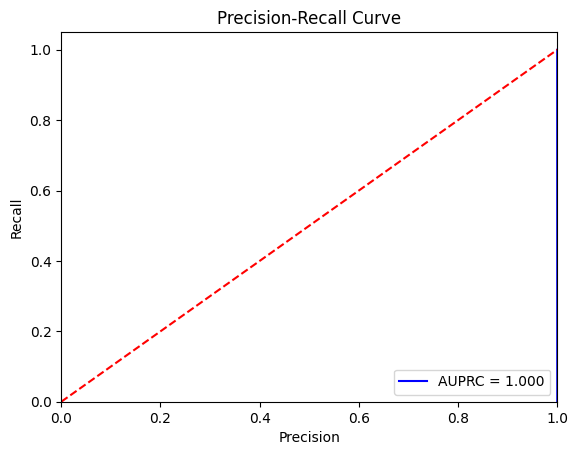

In [ ]:
precision, recall, _ = precision_recall_curve(y_dev, y_pred_dev)
auprc = average_precision_score(y_dev, y_pred_dev)
plt.title('Precision-Recall Curve')
plt.plot(precision, recall, 'b', label = 'AUPRC = %0.3f' % auprc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.show()

In [ ]:
confmat_train = confusion_matrix(y_dev, y_pred_dev)

<Axes: >

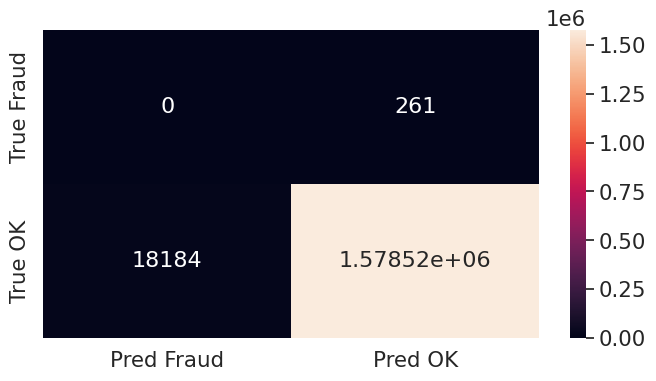

In [ ]:
confmat_train = pd.DataFrame(confmat_train,
                  ['True Fraud','True OK'],['Pred Fraud','Pred OK'])
plt.figure(figsize = (8,4))
sns.set(font_scale=1.4)# for label size
sns.heatmap(confmat_train, annot=True, annot_kws={"size": 16},fmt='g')

## Test Data

In [ ]:
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred_test)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred_test)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred_test)))
print("f1 Score: {:.3f}".format(f1_score(y_test, y_pred_test)))
print("Area Under the Precision-Recall Curve (AUPRC): {:.3f}".format(average_precision_score(y_test, y_pred_test)))

Accuracy: 0.989
Precision: 1.000
Recall: 0.989
f1 Score: 0.994
Area Under the Precision-Recall Curve (AUPRC): 1.000


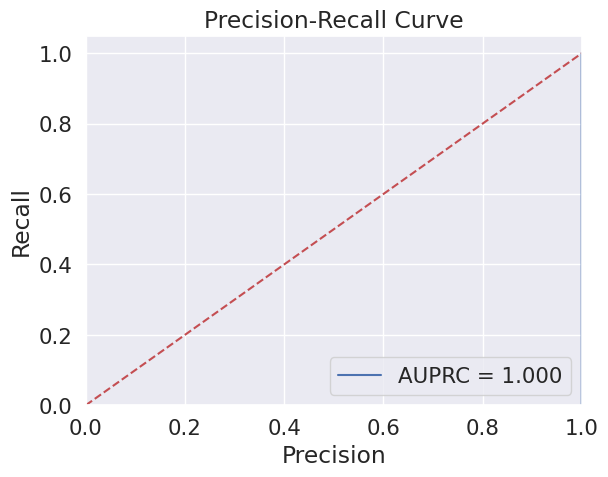

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)
auprc = average_precision_score(y_test, y_pred_test)
plt.title('Precision-Recall Curve')
plt.plot(precision, recall, 'b', label = 'AUPRC = %0.3f' % auprc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.show()

In [ ]:
confmat_test = confusion_matrix(y_test, y_pred_test)

<Axes: >

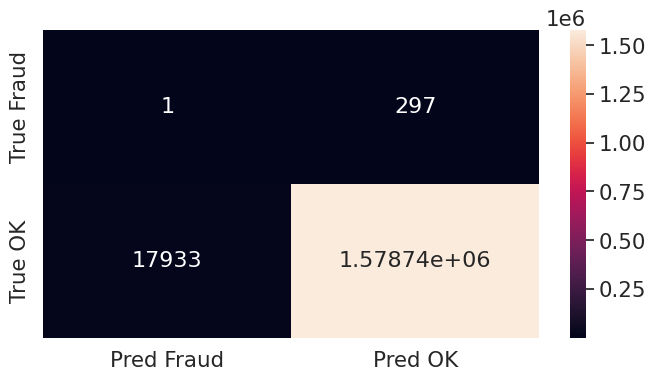

In [ ]:
confmat_train = pd.DataFrame(confmat_test,
                  ['True Fraud','True OK'],['Pred Fraud','Pred OK'])
plt.figure(figsize = (8,4))
sns.set(font_scale=1.4)# for label size
sns.heatmap(confmat_train, annot=True, annot_kws={"size": 16},fmt='g')